In [2]:
# Load our stuff
import pkgutil
from pathlib import Path
import numpy as np
from Bio import SeqIO
from SHMModels.fitted_models import ContextModel
from keras import optimizers, Input, Model
from keras.models import Sequential
import keras.backend as K
import matplotlib.pyplot as plt
from keras.layers import (
    Dense,
    TimeDistributed,
    SimpleRNN,
    Dropout,
    Conv2D,
    Conv2DTranspose,
    Flatten,
    Conv1D,
    MaxPooling2D,
    Reshape,
    UpSampling2D,
)
import scipy
import math


In [28]:
# First, we want to identify our true parameter set and our starting parameter set.
# GP OFFSET FIXED AT 12
n_samples = 10;max_steps = 4;n_imp_samples = 1;sampling_noise_sd = .01
def sample_prior():
    ls = np.random.uniform(low = -12.0, high = -2.0)
    sg = np.random.uniform(low = 5.0, high = 20.0)
    return { "base_rate" : 2.0,
                       "lengthscale" : np.exp(ls),
                       "gp_sigma" : sg,
                       "gp_ridge" : .01,
            "gp_offset": -10
            }

In [29]:
n = np.size(germline)
c_array = np.zeros(n)
for i in range(n):
    c_array[i] = 1.0 * (germline[i] == 'C')


In [94]:
def make_se_kernel(x, lengthscale, sigma, gp_ridge):
    D = np.zeros([len(x), len(x)])
    upper_tri = np.triu_indices(len(x), 1)
    D[upper_tri] = ((np.array(x)[upper_tri[0]] - np.array(x)[upper_tri[1]])**2)
    D += D.T
    K = sigma**2 * np.exp(-D / (2 * lengthscale))
    np.fill_diagonal(K, K.diagonal() + gp_ridge)
    return K

def forward_sample_sequence_sgcp(sequence, params, re):
    n = np.size(sequence)
    if re:
        random = np.random.normal(loc = 1.0, scale = 1.0)
    else:
        random = 0.0
    vals = np.random.poisson(lam = np.exp(np.log(params['base_rate'])+random), size = n)
    # Only include prelesions at c site
    vals = np.multiply(vals, c_array)
    x = []
    for i in range(np.size(vals)):
        if vals[i] > 0:
            conts = (i-np.random.uniform(size = 1))/n
            x = np.append(x, conts)
    N = np.size(x)
    if N > 0:
        K = make_se_kernel(x, params['lengthscale'], params['gp_sigma'], params['gp_ridge'])
        lambda_of_x = np.random.multivariate_normal(mean = np.zeros(N)+params['gp_offset'], cov = K)
        sigma_lambda_of_x = 1 / (1 + np.exp(lambda_of_x))
        uniforms = np.random.uniform(low = 0, high = 1, size = len(x))
        A_and_g = [(xi, li) for (xi, si, li, u) in zip(x, sigma_lambda_of_x, lambda_of_x, uniforms) if 0 < li]
        A_tilde_and_g = [(xi, li) for (xi, si, li, u) in zip(x, sigma_lambda_of_x, lambda_of_x, uniforms) if 0 >= li]
        A = [a for (a, g) in A_and_g]
        A_tilde = [at for (at, g) in A_tilde_and_g]
        g = [g for (a, g) in A_and_g + A_tilde_and_g]
    else:
        A = []
        A_tilde = []
        g = []
    return({ "A" : A, "A_tilde" : A_tilde, "g" : g})

def sample_seq(sequence, params, re):
    new_seq = sequence[:]
    res = forward_sample_sequence_sgcp(sequence,params, re)
    A = np.unique(np.ceil(np.multiply(res['A'],len(sequence))))
    muts = np.random.choice(a = ['A','G','T'], size = len(A))
    for i in range(len(A)):
        new_seq[int(A[i])] = muts[i]
    A_tilde = np.unique(np.ceil(np.multiply(res['A_tilde'],len(sequence))))
    g = res['g']
    return({"seq": new_seq,  "A" : A, "A_tilde" : A_tilde, "g" : g})
def process_latent(seq_res):
    n = len(seq_res['seq'])
    A = seq_res['A']
    A_tilde = seq_res['A_tilde']
    g = seq_res['g']
    A_long = np.zeros(n)
    A_tilde_long = np.zeros(n)
    g_long = np.zeros(n)
    k = 0
    for i in A:
        A_long[int(i)] = A_long[int(i)]+1
        g_long[int(i)] = g[k]
        k = k+1
    for i in A_tilde:
        A_tilde_long[int(i)] = A_tilde_long[int(i)]+1
        g_long[int(i)] = g[k]
        k = k+1
    return(np.stack([g_long,A_long, A_tilde_long],axis = 1))
def weight_array(ar, weights):
     sort = weights[np.argsort(ar)].cumsum()/np.sum(weights)
     sort_ar = np.sort(ar)
     return sort_ar,sort

In [46]:
# Get a 2d hot encoding of a sequence
def hot_encode_2d(seq):
    seq_hot = np.zeros((len(seq), 4, 1))
    for j in range(len(seq)):
        seq_hot[j, 0, 0] = seq[j] == "A"
        seq_hot[j, 1, 0] = seq[j] == "T"
        seq_hot[j, 2, 0] = seq[j] == "G"
        seq_hot[j, 3, 0] = seq[j] == "C"
    return seq_hot

def gen_batch(seq, params, batch_size, re):
    mut = []
    les = []
    preles = []
    gaus = []
    for i in range(batch_size):
        temp = sample_seq(seq, params, re)
        mut.append(temp['seq'])
        les.append(temp['A'])
        preles.append(temp['A_tilde'])
        gaus.append(temp['g'])
    return np.array(mut), np.array(les), np.array(preles), np.array(gaus)

In [79]:
def get_colocal(batch_size, model_params, sample = None, re = False):
    if sample is None:
        sample,A, A_t, g = gen_batch(germline, model_params, batch_size, re)
    base_prob = (1.0-np.mean(sample == germline))*(308.0/70.0)
    num = np.zeros(50)
    deno = np.zeros(50)
    for k in range(batch_size):
        for i in range(308):
            if c_array[i]:
                for j in range(i+1,np.min([i+50,307])):
                    if c_array[j]:
                        if sample[k,i] != germline[i]:
                            num[j-i] = num[j-i] + np.float(sample[k,j] != germline[j])
                        deno[j-i] = deno[j-i] + 1.0
    return num[1:],deno[1:],base_prob, sample
def gauss_kernel(x,y,eps):
    return np.exp(-(np.sum(np.square(x-y)))/(2*eps**2))

In [7]:
true_model_params = sample_prior()
obs_sample,A, A_t, g = gen_batch(germline,true_model_params, 300)

In [48]:
def importance_sample(obs_sequences,n_imp_samp, n, eps, random_effect = False):
    num, deno, base_prob, sample = get_colocal(n,true_model_params, sample = obs_sequences, re = random_effect)
    base_colocal = num/(deno*base_prob**2)
    ls_list = []
    w_list = []
    sg_list = []
    for i in range(n_imp_samp):
        model_params = sample_prior()
        num, deno, base_prob, sample = get_colocal(n,model_params)
        colocal = num/(deno*base_prob**2)
        weight = gauss_kernel(colocal[0:30:3], base_colocal[0:30:3],eps)
        if math.isnan(weight):
            print(colocal[0:30:3])
            print( base_colocal[0:30:3])
        w_list.append(weight)
        ls_list.append(model_params['lengthscale'])
        sg_list.append(model_params['gp_sigma'])
        if i % 50 == 0:
            print(i)
    return ls_list, w_list, base_colocal

In [9]:
ls_list, w_list, base_colocal = importance_sample(obs_sample, 1000, 300, 0.75)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


(array([7.50156391e+01, 3.06053050e-10, 6.81091619e-11, 7.22920727e-13,
        8.31823958e-15, 9.92023355e-14, 1.32780196e-21, 6.37734871e-13,
        7.35502782e-15, 2.58313245e-13]),
 array([6.15971487e-06, 1.33367133e-02, 2.66672670e-02, 3.99978206e-02,
        5.33283742e-02, 6.66589278e-02, 7.99894814e-02, 9.33200351e-02,
        1.06650589e-01, 1.19981142e-01, 1.33311696e-01]),
 <a list of 10 Patch objects>)

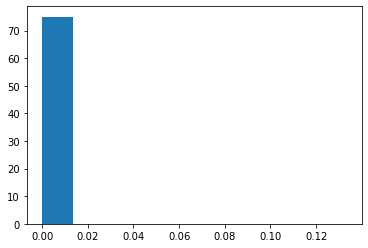

In [10]:
# Lengthscale of 0.001
plt.hist(np.array(ls_list), density = True, weights = np.array(w_list))

0.009885000000000234

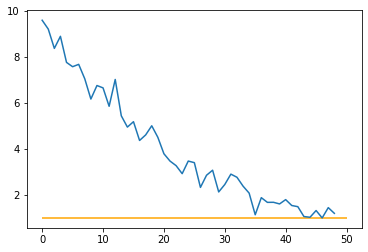

In [95]:
temp_params ={ "base_rate" : 0.1,
                       "lengthscale" :0.005,
                       "gp_sigma" : 8,
                       "gp_ridge" : .01,
              "gp_offset": -10
            }
num,deno,base_prob, sample = get_colocal(20000, temp_params, re = False)
plt.plot(num/(deno*base_prob**2))
plt.hlines(1.0, 0, 50 , colors = 'orange')

base_prob

0.01219214285714303

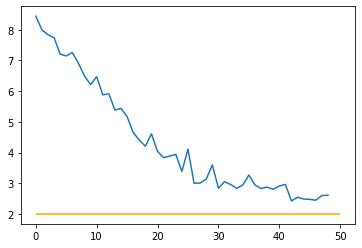

In [98]:
temp_params ={ "base_rate" : 0.01,
                       "lengthscale" :0.003,
                       "gp_sigma" : 17,
                       "gp_ridge" : .01,
              "gp_offset": -10
            }
num,deno,base_prob, sample = get_colocal(20000, temp_params, re = True)
plt.plot(num/(deno*base_prob**2))
plt.hlines(2.0, 0, 50 , colors = 'orange')

base_prob

In [11]:
est_sig = np.loadtxt("./est_sig")
true_sig = np.loadtxt("./true_sig")
est_ls = np.loadtxt("./est_ls")
true_ls = np.loadtxt("./true_ls")
est_rate = np.loadtxt("./est_rate")
true_rate = np.loadtxt("./true_rate")
est_re = np.loadtxt("./est_re")
true_re = np.loadtxt("./true_re")

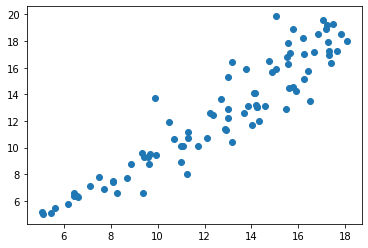

In [4]:
plt.scatter(est_sig,true_sig)

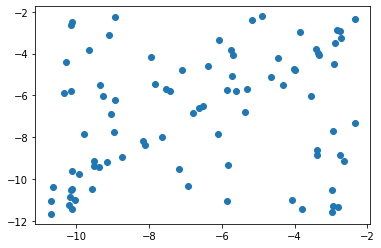

In [9]:
plt.scatter(np.log(est_ls[0:86]),np.log(true_ls))

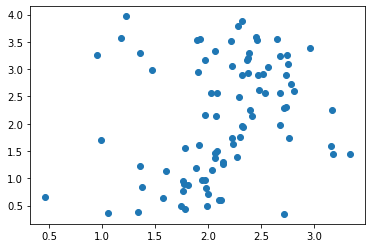

In [6]:
plt.scatter((est_rate),(true_rate))

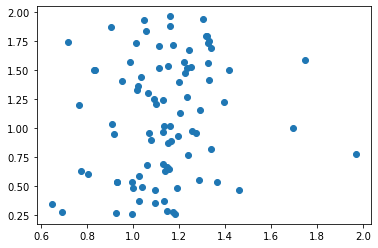

In [12]:
plt.scatter((est_re),(true_re))